# Analysis of July 7th 2022 Flight

Goal: 
1. Pick apart data to get idea of what went wrong.  
    2. Statistical plots on airspeed
    3. Correlations and Cross Correlations

4. Formulate Loiter Scoring Mechanism

In [16]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders
import plotly.express as px


In [17]:
# Importing data from BIN files #

#df = main.get_data("Alton", "june15_2022.BIN", "10ms")
#df = main.get_data("Alton", "july7_2022.BIN", "10ms")
#df = main.get_data("Alton","july8_2022.BIN", "100ms")

In [18]:
## Pickling that DF for Later ##

#df.to_pickle("./data/july7_2022_100Hz.pkl")

## Unpickling 
df_100Hz = pd.read_pickle("./data/july7_2022_100Hz.pkl")
#df_60Hz = pd.read_pickle("./data/june15_2022_60Hz.pkl")
#df_1Hz = pd.read_pickle("./data/june15_2022_1Hz.pkl")

df = df_100Hz.interpolate(method="linear")

From the plots before, 60 Hz looks sufficient to sample the highest sampled sensors.  In this case the IMU which samples at an average rate of 52 Hz.  However, in order to prevent aliasing, we will sample at twice that, based on the Nyquist Rate. 

Sampling rate of 100Hz is best.  

In [19]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_32040/2848444870.py:8: RuntimeWarning:

invalid value encountered in reciprocal

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_32040/2848444870.py:10: RuntimeWarning:

invalid value encountered in reciprocal

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_32040/2848444870.py:16: RuntimeWarning:

invalid value encountered in reciprocal

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_32040/2848444870.py:26: RuntimeWarning:

divide by zero encountered in true_divide

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_32040/2848444870.py:26: RuntimeWarning:

invalid value encountered in true_divide

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/propellers.py:114: RuntimeWarning:

invalid value encountered in add

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/propellers.py:122: RuntimeWarning:

invalid value encountered in subtract

/Users/williamkemp/Recor

Freewheel thrust coefficient:  -0.00804445463199624 
 Advance Ratio:  0.8386905840958647 
 CP Freewheel:  5.129680916149404e-10


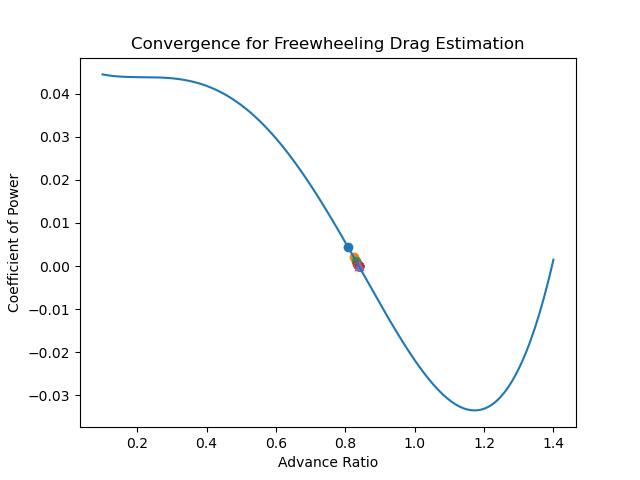

Propeller Drag[nan nan nan ...  0.  0.  0.]


/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/cl_finders.py:117: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/cl_finders.py:117: RuntimeWarning:

invalid value encountered in reciprocal

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/cl_finders.py:18: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/cl_finders.py:18: RuntimeWarning:

invalid value encountered in reciprocal



In [20]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter

v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

In [21]:
# Supplimental Values

df["PowerElectrical"] = df["EscCurrent"] * df["EscVoltage"]
df["Throttle"] = (df["Throttle"]-1100)*(1.0/800.0)

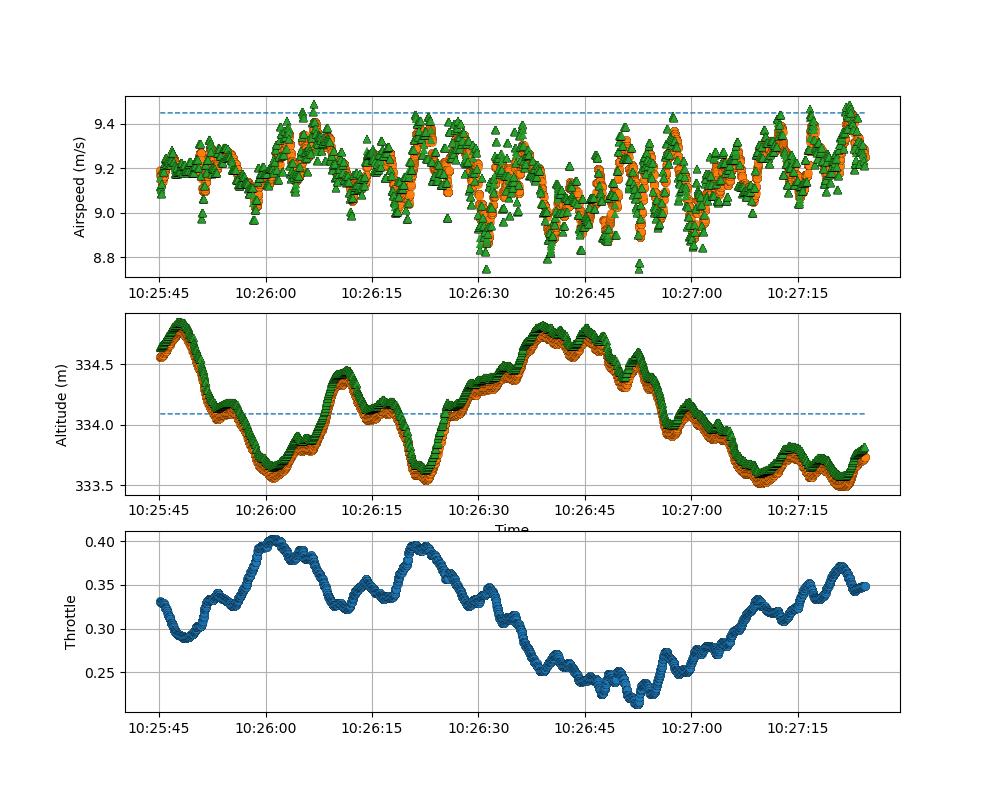

107.60394607825789


In [28]:
# Plotting Data Roughly
# Masking for heading angle range!
range = 3 # Range of heading in degrees
heading_mask = (df["Heading"] < 180 + (range/2)) & (df["Heading"] > 180-(range/2))
heading_mask = heading_mask.replace({True: 1, False: 0})
edge_mask = heading_mask.diff(periods=1)
loiter_mask = (edge_mask == 1) # Mask with True for beginning of each loiter
loiter_times = loiter_mask.loc[loiter_mask == True] # Loiter Series storing loiter number, start time, end time. 

loiter_number = 358 # Selecting the nth loiter of the flight for analysis
mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
segment = df[mask]

# Displaying Longitude/Lattitude for loiter
fig = px.scatter_mapbox(segment, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name=segment.index, 
                        #hover_data=["Address", "Listed"],
                        color="PowerElectrical",
                        color_continuous_scale='plasma',
                        size="PowerElectrical",
                        zoom=15, 
                        height=800,
                        width=1200)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Showing airspeed
plt.figure(figsize=(10,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(segment.index, segment.Airspeed_Demanded, linestyle='--', linewidth=1)
ax1.plot(segment.index, segment.Airspeed_CTUN, marker='o', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax1.plot(segment.index, segment.Airspeed_Sensor0, marker='^', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax1.set_ylabel("Airspeed (m/s)")
ax1.grid(True)
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')

# Showing Altitude
ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(segment.index, segment.Altitude_Demanded + segment.Altitude_Origin, linestyle='--', linewidth=1)
ax2.plot(segment.index, segment.Altitude_POS, marker='o', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax2.plot(segment.index, segment.Altitude_TECS + segment.Altitude_Origin, marker='^', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax2.set_xlabel("Time")
ax2.set_ylabel("Altitude (m)")
ax2.grid(True)
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')

# Showing Throttle
ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(segment.index, segment.Throttle, marker='o', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax3.set_ylabel("Throttle")
ax3.grid(True)
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')

plt.show()
print(segment.PowerElectrical.mean())


In [23]:

# Initializing Loiter Results Dataframe
frame = {'Heading': loiter_times}
loiter_results = pd.DataFrame(frame)

# Getting Characteristics of Flight
pelec_init = np.zeros(len(loiter_times))
airspeed_init = np.zeros(len(loiter_times))
airspeedvar_init = np.zeros(len(loiter_times))
# windspeed_init
throttle_init = np.zeros(len(loiter_times))
throttlevar_init = np.zeros(len(loiter_times))
altitudevar_init = np.zeros(len(loiter_times))


for loiter_index in np.arange(0,len(loiter_times)-1):
    mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_index], loiter_times.index[loiter_index+1])
    segment = df[mask]

    airspeed_init[loiter_index] = segment["Airspeed"].mean()
    airspeedvar_init[loiter_index] = segment["Airspeed"].var()
    pelec_init[loiter_index] = segment["PowerElectrical"].mean()
    throttle_init[loiter_index] = segment["Throttle"].mean()
    throttlevar_init[loiter_index] = segment["Throttle"].var()
    altitudevar_init[loiter_index] = segment["Altitude"].var()

loiter_results["LoiterNumber"] = np.arange(0,len(loiter_times-1))
loiter_results["AveragePower"] = pelec_init
loiter_results["AverageAirspeed"] = airspeed_init
loiter_results["VarianceAirspeed"] = airspeedvar_init
loiter_results["AverageThrottle"] = throttle_init
loiter_results["VarianceThrottle"] = throttlevar_init
loiter_results["VarianceAltitude"] = altitudevar_init

In [24]:
## Getting largest values
results = loiter_results.nlargest(int(len(loiter_results)*0.1), "AveragePower")

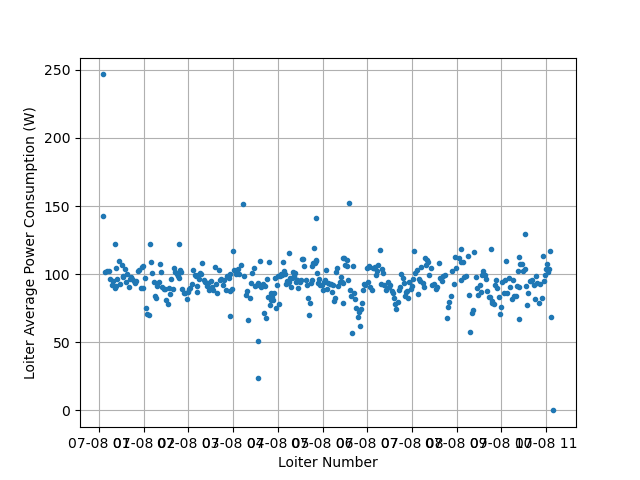

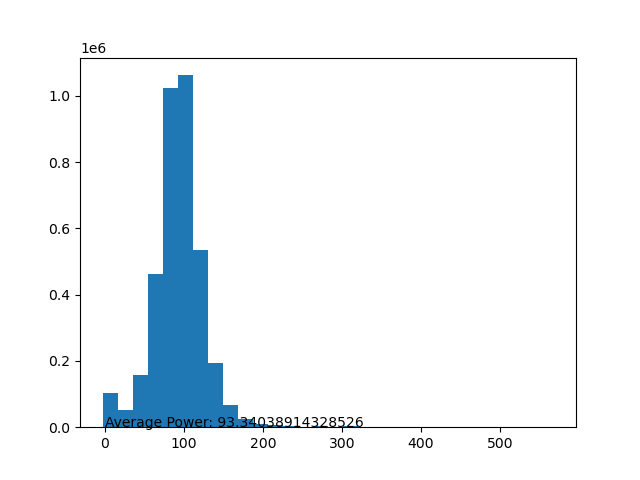

In [25]:
plt.figure()
plt.plot(loiter_results.AveragePower, linestyle='', marker='o', markersize=3)
plt.grid(True)
plt.xlabel("Loiter Number")
plt.ylabel("Loiter Average Power Consumption (W)")
plt.show()

plt.figure()
plt.hist(df["PowerElectrical"], bins=30)
plt.vlines(df["PowerElectrical"].mean(), 0, 300, colors='black')
plt.text(0, 300, "Average Power: " + str(df["PowerElectrical"].mean()))
plt.show()

In [26]:

# Getting Correlation Matrix
corrM = results.corr()
fig = px.imshow(corrM)
fig.update_layout(width=1200, height=1200)
fig.show()

NameError: name 'EAS' is not defined

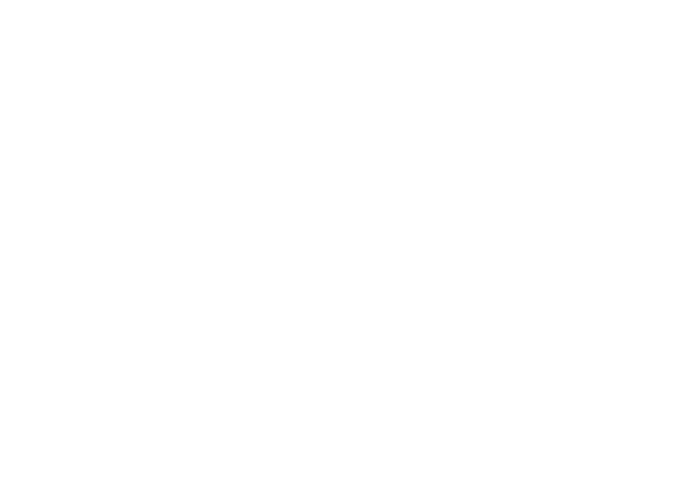

In [27]:
plt.figure(figsize=(7,5))
plt.plot(EAS, Peq_ct, label="Thrust Coefficient Method", color='green', linestyle='--')
plt.plot(EAS, Peq_eta, label="Eta Coefficient Method", color='purple', linestyle='--')
plt.plot(EAS, Peq_desc, label="Descending Method", color='orange', linestyle='--')
plt.plot(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='green', markeredgecolor=[0,0,0], label='CT Method Points')
plt.plot(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, linestyle='', marker='^', color='purple', markeredgecolor=[0,0,0], label='Eta Method Points')
plt.plot(EASdesc_ave, CDdesc_ave * 0.5 * 1.225 * EASdesc_ave**3 * createv.area, linestyle='', color='orange', marker='^', markeredgecolor=[0,0,0], label='Descending Method')
plt.xlabel("Airspeed (Standard Sea-Level)")
plt.ylabel("Power Required at Standard Mass (12.6 KG)")
plt.ylim([0, 120])
plt.legend()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()

In [ ]:
plt.figure(figsize=(10.6,6.5), dpi=100)
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, fmt='^', label="Eta Method", markeredgecolor=[0,0,0])
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, fmt='s', label="CT Method", markeredgecolor=[0,0,0])
plt.errorbar(CDdesc_ave, CLdesc_ave, xerr=CDdesc_std, yerr=CLdesc_std, fmt='o', label = "Descending Method", markeredgecolor=[0,0,0])
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()

In [ ]:
# Plotting time indexed flight data, not index based!

# Plotting true airspeed, with demanded airspeed
plt.figure(figsize=(10,5))
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, v_tas, label="Airspeed", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.plot(df.index, v_dem, label="Demanded Airspeed", marker='^', markeredgecolor=[0,0,0], markersize=3)
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    ax1.plot(df_1Hz.index[segment], np.ones(len(segment)), marker='v')
ax1.set_ylabel("Airspeeds (m/s)")
ax1.grid(True)
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, n, label='ESC Measurement')
ax2.set_ylabel("Motor Rotation Rate (rev/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.grid(True)
plt.legend()

plt.show()


In [ ]:

plt.figure(figsize=(10,5))
plt.plot(n)
plt.plot(np.transpose(np.where(n == 0)), n[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Motor Revolutions per Second")


plt.figure(figsize=(10,5))
plt.plot(J)
plt.plot(np.transpose(np.where(n == 0)), J[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Advance Ratio")

plt.figure(figsize=(10,5))
plt.plot(eff)
plt.plot(np.transpose(np.where(n == 0)), eff[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Expected Efficiency (System)")

plt.figure(figsize=(10,5))
plt.plot(Vd_tas)
plt.plot(np.transpose(np.where(n == 0)), Vd_tas[n == 0], linestyle='None', marker='o')
for i in range(len(desc_mask)):
    segment = np.arange(desc_mask[i,0],desc_mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Descent Rate (m/s)")
plt.show()

plt.figure(figsize=(7,5))

ax1 = plt.subplot(2,1,1)
ax1.plot(np.rad2deg(pitch))
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    ax1.plot(segment, np.zeros(len(segment)), marker='v')
ax1.grid(True)
#plt.ylabel("Pitch Angle (degrees)")

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(CL)
ax2.set_ylim([-1,2])
#plt.ylabel("Coefficient of")

plt.show()